In [1]:
import torch
import torch.nn as nn
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [4]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [5]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # (batch, seq_len) --> (batch, seq_len, d_model)
        # Multiply by sqrt(d_model) to scale the embeddings according to the paper
        return self.embedding(x) * math.sqrt(self.d_model)

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [7]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)


In [8]:
class ResidualConnection(nn.Module):
    
        def __init__(self, features: int, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization(features)
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class EncoderBlock(nn.Module):

    def __init__(self, features: int, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(features, dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [10]:
class Encoder(nn.Module):

    def __init__(self, features: int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(features)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [11]:
import torch
import torch.nn as nn
import math

# Reuse the existing components: InputEmbeddings, PositionalEncoding, LayerNormalization, etc.
# Modify only the components necessary for classification.

class TransformerEncoderClassifier(nn.Module):
    def __init__(self, 
                 src_vocab_size: int, 
                 src_seq_len: int, 
                 d_model: int, 
                 N: int, 
                 h: int, 
                 d_ff: int, 
                 num_classes: int, 
                 dropout: float = 0.1):
        super().__init__()
        # Input embedding and positional encoding
        self.src_embed = InputEmbeddings(d_model, src_vocab_size)
        self.src_pos = PositionalEncoding(d_model, src_seq_len, dropout)

        # Transformer encoder
        encoder_blocks = []
        for _ in range(N):
            self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
            feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
            encoder_block = EncoderBlock(d_model, self_attention_block, feed_forward_block, dropout)
            encoder_blocks.append(encoder_block)
        self.encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, src, src_mask):
        # Embed and encode the input
        src = self.src_embed(src)  # (batch, seq_len, d_model)
        src = self.src_pos(src)    # (batch, seq_len, d_model)
        encoder_output = self.encoder(src, src_mask)  # (batch, seq_len, d_model)

        # Aggregate features for classification
        # Mean pooling over the sequence length
        pooled_output = encoder_output.mean(dim=1)  # (batch, d_model)

        # Classification
        return self.classifier(pooled_output)

# Utility to create masks
def create_padding_mask(input_tensor, pad_token_idx):
    return (input_tensor != pad_token_idx).unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, seq_len)

# Hyperparameters and training setup
# src_vocab_size = 20000  # Adjust based on your dataset's vocabulary size
# src_seq_len = 512       # Maximum sequence length for a paragraph
# d_model = 256           # Embedding size
# N = 6                   # Number of encoder layers
# h = 8                   # Number of attention heads
# d_ff = 1024             # Feedforward network size
# num_classes = 14        # Number of topic classes
# dropout = 0.1

# # Instantiate the model
# model = TransformerEncoderClassifier(
#     src_vocab_size=src_vocab_size,
#     src_seq_len=src_seq_len,
#     d_model=d_model,
#     N=N,
#     h=h,
#     d_ff=d_ff,
#     num_classes=num_classes,
#     dropout=dropout
# )

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Dummy training loop
# def train_model(model, train_loader, num_epochs=10):
#     model.train()
#     for epoch in range(num_epochs):
#         for batch in train_loader:
#             paragraphs, labels = batch
#             optimizer.zero_grad()
            
#             # Create masks (assuming 0 is the PAD token)
#             src_mask = create_padding_mask(paragraphs, pad_token_idx=0)
            
#             # Forward pass
#             outputs = model(paragraphs, src_mask)  # (batch, num_classes)
            
#             # Compute loss
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")



In [12]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn

In [14]:
data = pd.read_csv('/kaggle/input/pre-data/preprocessed_data.csv')
data 

,Unnamed: 0,Paragraph,Topic
0,0,khoảng thiếu_niên ngụ xã thượng quận thị_xã ki...,0
1,1,hai xe đối_đầu tạo tiếng_động mạnh ba người đi...,0
2,2,camera hành_trình của ôtô đi trên đoạn đường đ...,0
3,3,camera hành_trình ghi lại vụ tai_nạn sáng,0
4,4,đoạn đường xảy ra tai_nạn không có dải_phân_cá...,0
...,...,...,...
29995,29995,tiếc thay đó cũng không phải lần cuối rắc_rối ...,14
29996,29996,ngày thắng kiện tôi lặng_lẽ về dọn đồ của mẹ r...,14
29997,29997,từ lúc hiểu ra_điều đó tôi đã hoàn_toàn buông_...,14
29998,29998,hiện_nay nhiều người có cái nhìn khá phiến_diệ...,14


In [18]:
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np


In [19]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


# Load the PhoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")



# Hyperparameters and training setup
max_len = 15
src_vocab_size = tokenizer.vocab_size   # Adjust based on your dataset's vocabulary size
src_seq_len = 512                       # Maximum sequence length for a paragraph
d_model = 256                           # Embedding size
N = 6                                   # Number of encoder layers
h = 8                                   # Number of attention heads
d_ff = 1024                             # Feedforward network size
num_classes = 15                        # Number of topic classes
dropout = 0.2                           # Dropout rate
batch_size = 64                         # Number of samples per batch
epochs = 40                             # Number of epochs
learning_rate = 0.001                   # Learning rate


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [20]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
        data['Paragraph'],
        data['Topic'],
        test_size=0.2,
        random_state=42,
        stratify=data['Topic']  
    )


X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp  
)


def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize train, validation, and test sets
X_train_token = tokenize_texts(X_train, tokenizer)
X_val_token = tokenize_texts(X_val, tokenizer)
X_test_token = tokenize_texts(X_test, tokenizer)

# Create PyTorch datasets
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = CustomDataset(X_train_token, y_train.values)
val_dataset = CustomDataset(X_val_token, y_val.values)
test_dataset = CustomDataset(X_test_token, y_test.values)

# DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn

if __name__ == "__main__":
    # Model initialization
    model = TransformerEncoderClassifier(
        src_vocab_size=src_vocab_size,
        src_seq_len=src_seq_len,
        d_model=d_model,
        N=N,
        h=h,
        d_ff=d_ff,
        num_classes=num_classes,
        dropout=dropout
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Histories for tracking
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Training loop
    def train_model(model, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for batch in train_loader:
                paragraphs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                optimizer.zero_grad()

                # Create masks (assuming 0 is the PAD token)
                src_mask = create_padding_mask(paragraphs, pad_token_idx=0)

                # Forward pass
                outputs = model(paragraphs, src_mask)  # (batch, num_classes)

                # Compute loss
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total
            train_loss_history.append(train_loss)
            train_acc_history.append(train_accuracy)

            # Validation step
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in val_loader:
                    paragraphs, labels = batch['input_ids'].to(device), batch['labels'].to(device)
                    src_mask = create_padding_mask(paragraphs, pad_token_idx=0)
                    outputs = model(paragraphs, src_mask)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct / total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_accuracy)

            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Train the model
    train_model(model, train_loader, val_loader, num_epochs=epochs)


Epoch 1/40, Train Loss: 1.9723, Train Accuracy: 37.00%, Val Loss: 1.4416, Val Accuracy: 60.63%
Epoch 2/40, Train Loss: 1.1691, Train Accuracy: 64.51%, Val Loss: 1.1845, Val Accuracy: 69.73%
Epoch 3/40, Train Loss: 0.9277, Train Accuracy: 71.66%, Val Loss: 1.0565, Val Accuracy: 72.73%
Epoch 4/40, Train Loss: 0.7461, Train Accuracy: 77.36%, Val Loss: 0.9655, Val Accuracy: 75.57%
Epoch 5/40, Train Loss: 0.6292, Train Accuracy: 80.81%, Val Loss: 0.9871, Val Accuracy: 75.23%
Epoch 6/40, Train Loss: 0.5336, Train Accuracy: 83.23%, Val Loss: 0.9629, Val Accuracy: 78.43%
Epoch 7/40, Train Loss: 0.4599, Train Accuracy: 85.53%, Val Loss: 0.9373, Val Accuracy: 78.73%
Epoch 8/40, Train Loss: 0.3813, Train Accuracy: 88.09%, Val Loss: 0.9947, Val Accuracy: 78.90%
Epoch 9/40, Train Loss: 0.3320, Train Accuracy: 89.52%, Val Loss: 1.0078, Val Accuracy: 79.73%
Epoch 10/40, Train Loss: 0.2948, Train Accuracy: 90.47%, Val Loss: 1.0269, Val Accuracy: 79.50%
Epoch 11/40, Train Loss: 0.2611, Train Accuracy: 

In [22]:
torch.save(model.state_dict(), "transformer_model.pth")

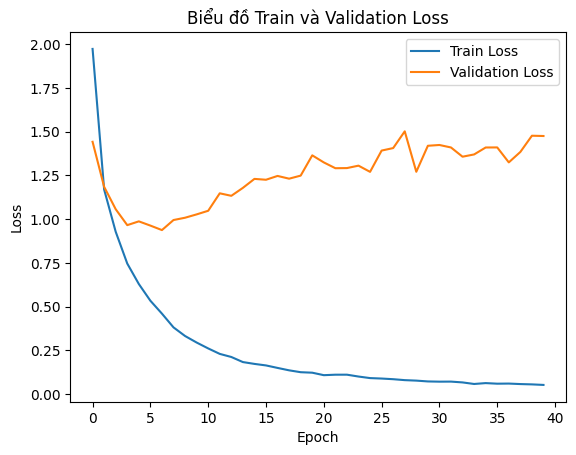

In [23]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Biểu đồ Train và Validation Loss')
plt.show()

In [24]:
def evaluate_model(model, test_loader, device):
    """
    Đánh giá mô hình trên tập test
    Args:
        model (nn.Module): Mô hình MLP
        test_loader (DataLoader): Dataloader cho tập test
        device (str): GPU hoặc CPU
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            embeddings, labels = batch['input_ids'].to(device), batch['labels'].to(device)
            outputs = model(embeddings, create_padding_mask(embeddings, pad_token_idx=0))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    test_accuracy = 100 * correct / total
    print(f"Accuracy on Test set: {test_accuracy:.2f}%")
    return test_accuracy

In [25]:
test_accuracy = evaluate_model(model, test_loader, device)

Accuracy on Test set: 81.87%


In [26]:
def evaluate_and_add_predictions(model, test_loader, df_test, device):
    """
    Đánh giá mô hình trên tập test và thêm cột "predict" vào DataFrame
    Args:
        model (nn.Module): Mô hình MLP
        test_loader (DataLoader): DataLoader cho tập test
        df_test (DataFrame): DataFrame chứa thông tin của tập test (cột Topic)
        device (str): GPU hoặc CPU
    Returns:
        DataFrame: DataFrame có thêm cột "predict" (nhãn dự đoán)
    """
    model.to(device)
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['input_ids'].to(device)
            outputs = model(embeddings, create_padding_mask(embeddings, pad_token_idx=0))
            _, predicted = torch.max(outputs, 1)  # Lấy nhãn dự đoán
            all_preds.extend(predicted.cpu().numpy())  # Chuyển kết quả về CPU và lưu vào all_preds
    
    # Thêm cột predict vào DataFrame
    df_test['predict'] = all_preds  # Thêm cột nhãn dự đoán
    df_test['correct'] = (df_test['predict'] == df_test['Topic'])  # Thêm cột đánh dấu đúng/sai
    print(f"\n Đã thêm cột 'predict' và 'correct' vào DataFrame.")
    
    # Hiển thị các mẫu mà mô hình phân loại sai
    df_errors = df_test[df_test['correct'] == False]  # Lọc các mẫu sai
    print(f" Số mẫu phân loại sai: {len(df_errors)} trên tổng số {len(df_test)} mẫu.")
    
    print("\n Ví dụ các mẫu phân loại sai:")
    print(df_errors[['Paragraph', 'Topic', 'predict']])  # Hiển thị 10 mẫu sai đầu tiên
    
    return df_test

In [27]:
df_test = pd.DataFrame({'Paragraph': X_test, 'Topic': y_test})

In [28]:
df_test = evaluate_and_add_predictions(model, test_loader, df_test, device)


 Đã thêm cột 'predict' và 'correct' vào DataFrame.
 Số mẫu phân loại sai: 544 trên tổng số 3000 mẫu.

 Ví dụ các mẫu phân loại sai:
                                               Paragraph  Topic  predict
14516  evin cetin tác_giả của một cuốn sách về các bă...      7        5
1638   ba bồn in tên logo của một công_ty sản_xuất co...      0        3
6597   theo ông hải quy_định mới có_thể gây áp_lực ba...      3        2
17057  một mô_hình đã gặp chút trục_trặc nhưng chúng_...      8       12
29849      tôi nhàn tênh vì con học như_chơi suốt năm mỹ     14        5
...                                                  ...    ...      ...
5125   bên cạnh đó các nhà cung_cấp hoạt_động_kinh_do...      2       12
24242  tuy_nhiên chính_phủ indonesia từ_chối cho rằng...     12        2
5442   bà dẫn_chứng nước dừa đóng_hộp nước dừa tự_nhi...      2       14
1808   do xây_dựng từ lâu dẫn tới xuống_cấp công_trìn...      0        3
24740  luật có_thể không tự nó cải_thiện tiêu_chuẩn a...     12 

In [29]:
df_test

,Paragraph,Topic,predict,correct
8821,hố này trải rộng triệu km và cách ấn độ km về ...,4,4,True
12951,bàn thắng của mbappe khiến tôi nhẹ_nhõm ông ch...,6,6,True
10970,timothée chalamet sinh năm sinh tại new york t...,5,5,True
24727,theo dự_thảo về luật sửa_đổi an_toàn trực_tuyế...,12,12,True
24303,ông phan trần thành phó_giám_đốc ngành_hàng ap...,12,12,True
...,...,...,...,...
10865,ca_sĩ hoàng hải trái và vũ_thảo_my cùng diện s...,5,5,True
10358,ca_sĩ erik là một trong số sao theo_đuổi mốt n...,5,5,True
25581,theo fpt nhờ tính_năng ai conversation người d...,12,12,True
28471,điều tôi thấy là vấn_đề giao_thông ùn_tắc khôn...,14,14,True
